# SSD Jet Detection Inference Example

In [1]:
# Import GPU libs

import setGPU
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

setGPU: Setting GPU to: 0


In [2]:
# Other imports

import numpy as np
import simplejson as json

In [3]:
# Set presentation settings

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tick

from matplotlib import cm
from matplotlib.colors import SymLogNorm
from mpl_toolkits import mplot3d

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 6.0)

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Anonymous Pro for Powerline']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

with open('./data/palette.json') as json_file:
    color_palette = json.load(json_file)
    
colors = [color_palette['lightBlue']['shade_300'],
          color_palette['lime']['shade_300'],
          color_palette['purple']['shade_300'],
          color_palette['teal']['shade_300'],
          color_palette['grey']['shade_300']]

In [4]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
from keras import backend as K
from keras.models import load_model

from ssd.generator import DataGenerator
from ssd.keras_ssd7 import build_model
from ssd.ssd_output_decoder import decode_detections

Using TensorFlow backend.


In [6]:
# Model configuration parameters

DATA_SOURCE = '/eos/user/a/adpol/ceva/fast'
SAVE_DESTINATION = '/data/adpol'
MODEL_NAME = 'ceva-cms-jet-ssd-3d'
NUMBER_OF_PREDICTIONS = 10
CLASSES = ['background', 'b', 'h', 'W', 't', 'q']

img_height = 452 # Pixel height
img_width = 340 # Pixel width
img_channels = 3
n_classes = 4 # Number of target classes

# Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_mean = None 
intensity_range = None

# An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
scales = [0.16, 0.4, 0.6, 0.8, 0.96]
# The list of aspect ratios for the anchor boxes
aspect_ratios = [1.0]
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = True # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [15]:
# Compile the model

K.clear_session()

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='inference',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range,
                    confidence_thresh=0.45,
                    iou_threshold=0.45,
                    top_k=10)

# Load model
model.load_weights('%s/%s.h5' % (SAVE_DESTINATION, MODEL_NAME), by_name=True)

In [8]:
# Validation data generator

val_dataset = DataGenerator(hdf5_dataset_path='%s/RSGraviton_NARROW_0.h5' % DATA_SOURCE)
#val_dataset = DataGenerator(hdf5_dataset_path='%s/udacity.h5' % DATA_SOURCE)

Processing labels for /eos/user/a/adpol/ceva/fast/RSGraviton_NARROW_0.h5
Loading labels: 100%|██████████| 10000/10000 [00:01<00:00, 5145.67it/s]


In [9]:
def plot_calo_image(pixels, batch_labels, y_pred_decoded):
                    
    fig = plt.figure(figsize=(16, 6))
    ax1 = plt.subplot(121)

    cmap = matplotlib.cm.viridis

    # Plot calorimeter Pt and jets
    ax1 = plt.gca()
    ax1.set_xlim([-15, 356])
    ax1.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)

    def x_axis_formatter(x, y):
        x = x - 46
        if x < 0:
            x = x + 360
        if x > 360:
            x = x - 360
        return int(x)

    ax1.yaxis.set_major_formatter(tick.FuncFormatter(x_axis_formatter))
    ax1.set_ylim([-15, 375+2*46])
    ax1.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)

    # Show energy deposits
    im = ax1.imshow(pixels,
                    norm=SymLogNorm(linthresh=0.03,
                                    vmin=0,
                                    vmax=pixels.max()),
                    interpolation="nearest",
                    cmap=cmap)
    
    # Add scale
    cbar = fig.colorbar(im, extend='max')
    cbar.set_label('$E_T$ [GeV]', rotation=90, horizontalalignment='right', y=1.0)
    
    # Add ground truth
    for box in batch_labels[i]:
        xmin = box[1]
        ymin = box[2]
        xmax = box[3]
        ymax = box[4]
        
        jet = patches.Rectangle((xmin, ymin),
                                xmax-xmin,
                                ymax-ymin,
                                linewidth=2,
                                alpha=0.7,
                                edgecolor=color_palette['red']['shade_600'],
                                facecolor='none')
        ax1.add_patch(jet)
        ax1.text(xmin,
                 ymin,
                 '{}'.format(CLASSES[int(box[0])]),
                 weight='bold',
                 color=color_palette['grey']['shade_100'],
                 bbox={'facecolor': color_palette['red']['shade_900'], 'alpha': 1.0})

    # Draw the predicted boxes
    for box in y_pred_decoded:

        xmin = box[1]
        ymin = box[2]
        xmax = box[3]
        ymax = box[4]
        
        if xmin < 0:
            xmin=0
        
        if ymax > 460:
            ymax = 460
        color = colors[int(box[0])]
        
        jet = plt.Rectangle((xmin, ymin),
                            xmax-xmin,
                            ymax-ymin,
                            edgecolor=color,
                            alpha=0.7,
                            facecolor='none',
                            linewidth=2)

        ax1.add_patch(jet)
        ax1.text(xmin,
                 ymin,
                 '{}: {:.2f}'.format(CLASSES[int(box[0])], box[1]),
                 weight='bold',
                 color='#FAFAFA',
                 bbox={'facecolor': color, 'alpha': 1.0})

    # Add CMS tag
    ax1.text(0,
             1.04,
             "CMS",
             weight='bold',
             verticalalignment="top",
             horizontalalignment="left",
             transform=ax1.transAxes,
             color="black",
             fontsize=16)

    # Add title
    ax1.set_title('ECAL $E_T$', loc="right")

    # Show plot
    plt.show();

In [16]:
# Predictions generator

predict_generator = val_dataset.generate(batch_size=NUMBER_OF_PREDICTIONS,
                                         shuffle=True,
                                         label_encoder=None,
                                         returns={'image_ids',
                                                  'processed_images',
                                                  'processed_labels'})

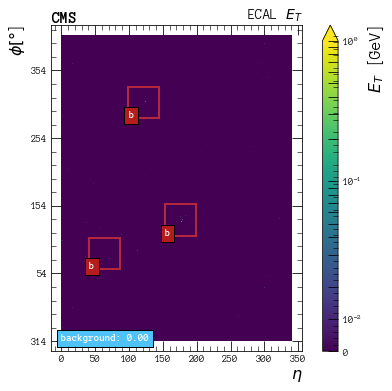

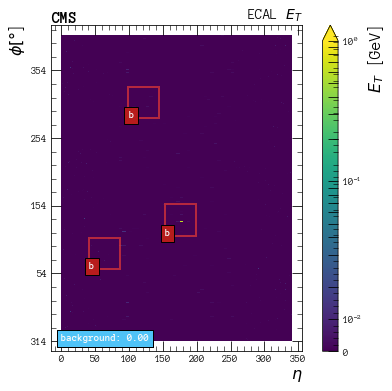

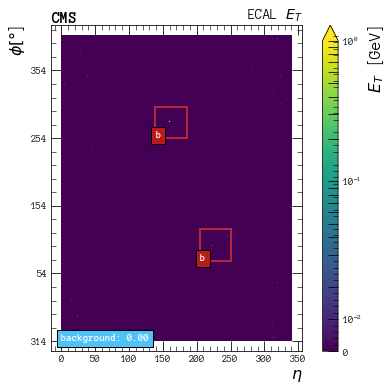

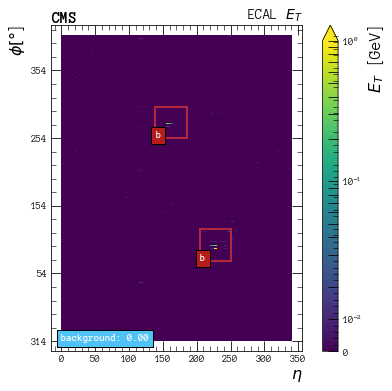

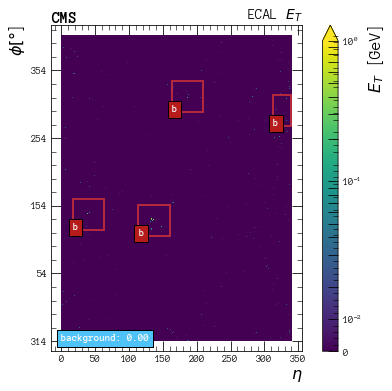

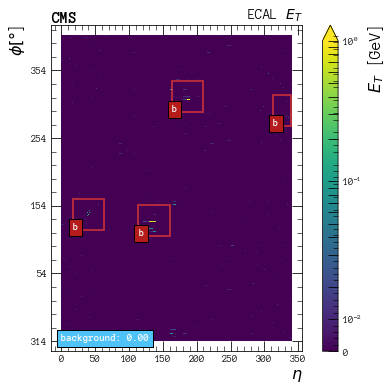

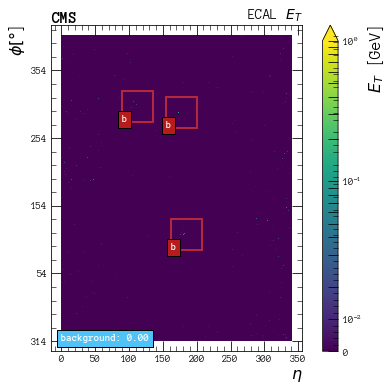

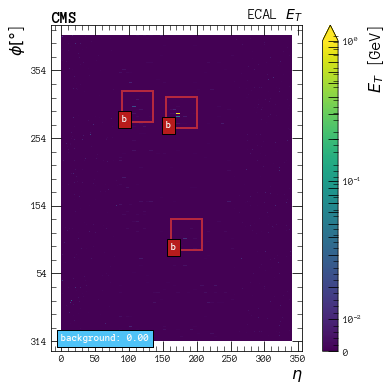

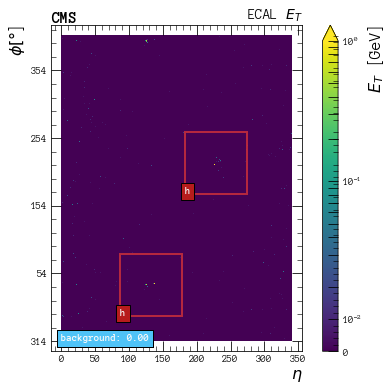

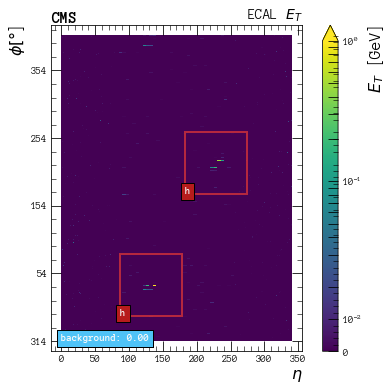

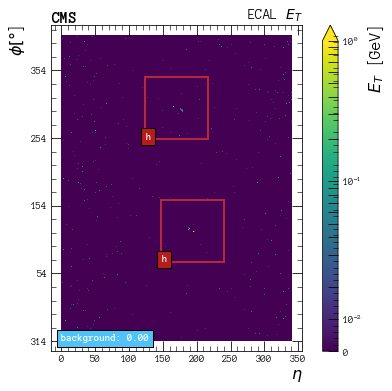

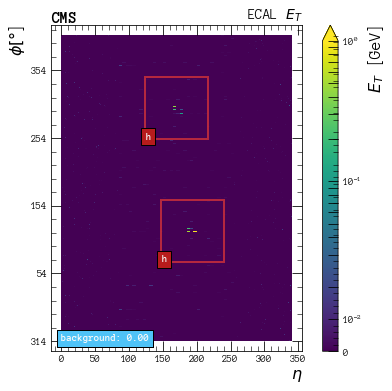

In [ ]:
# Make predictions

ids, batch_images, batch_labels = next(predict_generator)

y_pred = model.predict(batch_images)


for i in np.arange(NUMBER_OF_PREDICTIONS):
    calorimeter = np.rollaxis(batch_images[i], 2, 0)
#     print(y_pred[i])
#     print(batch_labels[i])
#     print()
    #print(ids[i])
    plot_calo_image(calorimeter[0], batch_labels, y_pred[i])
    plot_calo_image(calorimeter[1], batch_labels, y_pred[i])